Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, norm
import warnings
warnings.filterwarnings("ignore")
from tqdm.auto import tqdm
import requests
from urllib.parse import urlencode
plt.style.use('ggplot')

Подгружаем имеющиеся данные

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
with open('groups.csv', 'wb') as f:  
    f.write(download_response.content)
df1 = pd.read_csv('groups.csv', sep=';')

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/3aARY-P9pfaksg' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
with open('groups_add.csv', 'wb') as f: 
    f.write(download_response.content)
df2 = pd.read_csv('groups_add.csv')

In [4]:
df1.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
df1.shape

(74484, 2)

In [6]:
df2.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [7]:
df2.shape

(92, 2)

In [8]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
with open('active_studs.csv', 'wb') as f:   
    f.write(download_response.content)
df3 = pd.read_csv('active_studs.csv')

In [9]:
df3.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [10]:
df3.shape

(8341, 1)

In [11]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/84hTmELphW2sqQ' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
with open('checks.csv', 'wb') as f:   
    f.write(download_response.content)
df4 = pd.read_csv('checks.csv', sep=';')

In [12]:
df4.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [13]:
df4.shape

(541, 2)

Объединяем df1 и df2 (информацию о принадлежности пользователей к контрольной или экспериментальной группе)

In [14]:
df = pd.concat([df1, df2], ignore_index=True)

In [15]:
df.shape

(74576, 2)

In [16]:
df.shape

(74576, 2)

<AxesSubplot:>

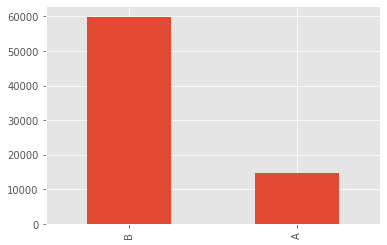

In [17]:
df.grp.value_counts().plot(kind='bar')

In [18]:
df.grp.value_counts(normalize=True) * 100

B    80.297951
A    19.702049
Name: grp, dtype: float64

Контрольная и целевая группы пользователей не сбалансированы. В контрольную группу отнесены 20% пользователей, в целевой группе оказались 80% пользователей.

Помечаем тех пользователей, которые зашли на платформу в дни проведения эксперимента 

In [19]:
lst_st_id = df3.student_id.to_list()

In [20]:
len(lst_st_id)

8341

In [21]:
df_add = df.query('id in @lst_st_id')
df_add['participant'] = 1

In [22]:
df = df_add.merge(df, how='right', on=['id', 'grp']).fillna(0).astype({'participant': 'int'})

A – контроль (те пользователи, у которых осталась базовая механика оплаты услуг на сайте),
B – целевая группа (те пользователи, которым была предложена новая механика оптаты услуг на сайте)

In [23]:
df.query('participant == 1').grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [24]:
df.participant.value_counts(normalize=True) * 100

0    88.815437
1    11.184563
Name: participant, dtype: float64

В дни проведения эксперимента только 11% пользователей зашли на платформу.

Добавляем в df информацию об оплатах пользователей в дни проведения эксперимента

In [25]:
df4.rename(columns={'student_id': 'id'}, inplace=True)

In [26]:
df = df.merge(df4, how='left', on='id')

In [27]:
df.fillna(0, inplace=True)

In [28]:
df.head()

,id,grp,participant,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0


In [29]:
df[(df.rev > 0) & (df.participant == 1)].shape[0] / df[df.participant == 1].shape[0] * 100

4.699676297806018

Только 5% из тех пользователей, которые посетили платформу в дни проведения эксперимента, совершили оплату.

В ходе анализа будем смотреть на следующие метрики:
1. Средний доход от оплат услуг пользователями, поскольку данная метрика здесь является целевой, именно она по большей части отражает, насколько эффективна новая механика оплаты услуг на сайте.
2. Доля платящих пользователей, с помощью данной метрики сравним, увеличилась ли в тестовой группе доля тех пользователей, которые пользуются оплатой услуг, по сравнению с аналогичным показателем по контрольной группе.
3. ARPPU – средний доход на платящего пользователя, поскольку базовая механика оплаты услуг на сайте могла быть сложна для понимания и неочень удобна пользователям, и как следствие, они могли быть не положительно настроены на покупку, и как следствие, совершать покупки в меньшем объеме, чем при использовании новой механики оплаты.

1. Средний доход от оплат услуг пользователями

– группа A (контрольная)

In [30]:
df[df.grp == 'A']['rev'].mean()

6.268018784455183

– группа B (тестовая)

In [31]:
df[df.grp == 'B']['rev'].mean()

8.03617059265568

Итак, средний доход от оплат услуг пользователями, для которых была предложена новая механика оплаты услуг на сайте, выше, чем аналогичный показатель по пользователям, использовавшим старую механику оплаты услуг.
Такое различие в значениях показателя действительно может быть связано с более высокой степенью удобства новой механики для пользователей.
Однако, только этой информации недостаточно для принятия решения о запуске новой механики на всех пользователей. Посмотрим на другие показатели.

2. Доля платящих пользователей

– группа A (контрольная)

In [32]:
df[(df.grp == 'A') & (df.rev > 0)].shape[0] / df[df.grp == 'A'].shape[0] * 100

0.7282379364323147

– группа B (тестовая)

In [33]:
df[(df.grp == 'B') & (df.rev > 0)].shape[0] / df[df.grp == 'B'].shape[0] * 100

0.7247465891822387

Итак, доля платящих пользователей в контрольной группе оказалась немного выше, чем в целевой.
Однако, также стоит сравнить и средний доход на платящего пользователя по исследуемым группам.

3. ARPPU – средний доход на платящего пользователя

– группа A (контрольная)

In [34]:
df[(df.grp == 'A') & (df.rev > 0)]['rev'].mean()

860.7102803738318

– группа B (тестовая)

In [35]:
df[(df.grp == 'B') & (df.rev > 0)]['rev'].mean()

1108.8248930875575

Здесь видим, что средний доход на платящего пользователя по целевой группе значительно выше, чем по контрольной группе. 
Проведем A/B тестирование, чтобы убедиться, что найденные различия значимы.

В отдельный датафрейм отберем тех пользователей, которые являлись участниками эксперимента и которые совершили целевое действие, т.е. произвели оплату услуг.

Обоснование взятия ARPPU в качестве целевой метрики:

Поскольку была рассчитана доля платящих пользователей (CR), как отношение количества пользователей, совершивших целевое действие, т.е. покупку, к количеству всех посетителей сайта, которая показала незначимое отличие по группам A и B (в группе A данный показатель немного выше.)
Таким образом, мы можем исключить ситуацию, когда CR значительно проседает на фоне растущей выручки.
Поэтому в качестве целевой метрики выберем ARPPU.



In [36]:
df_part = df.query('rev > 0')

In [37]:
df_part

,id,grp,participant,rev
1,1627,A,1,990.0
39,3185,B,0,690.0
121,25973,B,0,690.0
125,26280,B,0,690.0
220,100300,B,1,990.0
...,...,...,...,...
74365,5645737,B,1,1900.0
74381,5651566,B,1,1900.0
74402,5662322,B,1,1900.0
74452,5681918,B,1,1900.0


<AxesSubplot:>

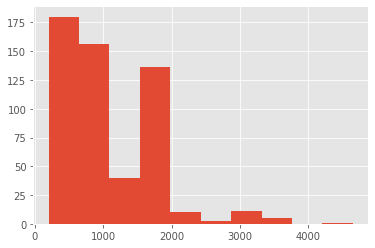

In [38]:
df_part.rev.hist()

Посмотрим на распределение дохода от оплат услуг пользователями для тестовой и целевой групп

<AxesSubplot:>

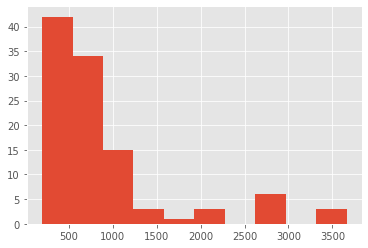

In [39]:
df_part[df_part.grp == 'A']['rev'].hist()

<AxesSubplot:>

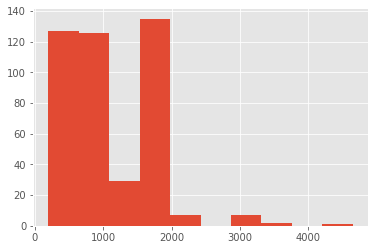

In [40]:
df_part[df_part.grp == 'B']['rev'].hist()

Для обеих групп пользователей вид распределения дохода далеко от симметричного, в обоих случаях оно скошенно вправо, и, кроме того, наблюдаются выбросы, поэтому на средние значения доходов ориентироваться не стоит, нужно смотреть на медиану.

In [41]:
pd.DataFrame.from_dict({'mean A': df_part.query('grp == "A"').rev.mean(),
                        'mean B': df_part.query('grp == "B"').rev.mean(),
                        'median A': df_part.query('grp == "A"').rev.median(),
                        'median B': df_part.query('grp == "B"').rev.median()},
                       orient='index').rename({0: 'value'}, axis=1)

,value
mean A,860.710280
mean B,1108.824893
median A,690.000000
median B,935.000000


Итак, в целом, можно заметить, что и средние, и медианы достаточно сильно отличаются по группам пользователей – для обоих показателей значения в целевой группе (группе B), пользователям которой была предложена новая механика оплаты услуг на сайте, выше. Теперь необходимо понять, значимы ли эти различия.  

По построенным графикам можно сделать весьма очевидный вывод, что рапределение доходов от оплат услуг ползователями не нормально, поэтому для проверки статистических гипотез используем критерий Краскела-Уоллиса.
Проверку гипотез будем осуществлять на уровне значимости 0,05.

In [42]:
mannwhitneyu(df_part[df_part.grp == "A"]['rev'], df_part[df_part.grp == "B"]['rev'])[1]

9.658027498190076e-05

Таким образом, разница в доходах, полученных от оплаты услуг пользователями из группы А и из группы В, есть (p-value < 0.05 => H0 о незначимости различий отвергается). 

Для применения бустрапа разделим общую совокупность наблюдений на две части – control (группа A) и test (группа B).

In [43]:
df_test = df_part.query('grp == "B"')[['rev']]
df_control = df_part.query('grp == "A"')[['rev']]

Применим бутстрап (с np.mean) и критерий mann-whitney, а потом сравним p-value

100%|██████████| 2000/2000 [00:00<00:00, 5310.29it/s]


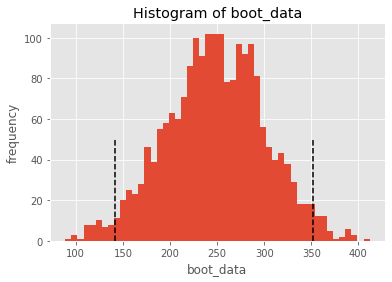

In [44]:
def get_bootstrap(data_column_1,
                  data_column_2, boot_it=1000, statistic=np.mean,
                  bootstrap_conf_level=0.95):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(boot_len,
                                         replace=True).values
        samples_2 = data_column_2.sample(boot_len,
                                         replace=True).values
        boot_data.append(statistic(samples_1 - samples_2))
    pd_boot_data = pd.DataFrame(boot_data)
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    p_1 = norm.cdf(x=0,
                   loc=np.mean(boot_data),
                   scale=np.std(boot_data))
    p_2 = norm.cdf(x=0,
                   loc=-np.mean(boot_data),
                   scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2
    plt.hist(pd_boot_data[0], bins=50)
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--', color='black')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    return {"boot_data": boot_data,
            "ci": ci, "p_value": p_value}


booted_data = get_bootstrap(df_test, df_control, boot_it=2000)

В целом, по графику можно отметить, что наблюдается симметрия в бутстрап-распределении средних (отсуствует сильно выраженная скошенность распределения влево или вправо).

Значение p-value, найденное с помощью бутстрапа

In [45]:
booted_data["p_value"]

2.1554943685681616e-06

Доверительный интервал оценки разницы средних

In [46]:
booted_data["ci"]

,0
0.025,141.966482
0.975,351.318153


In [47]:
mannwhitneyu(df_test, df_control)[1]

9.658027498190076e-05

1. Итак, значение p-value, найденное с помощью бутстрапа, говорит о том, что нам следует отклонить гипотезу H0 о незначимости различий средних в выборках Test и Control, т.е. средние значения Revenue в выборках Test и Control с вероятностью 0,95 различаются.
2. Аналогичный вывод позволяет сделать и рассчитанный доверительный интервал для разницы в средних значениях – 0 не попадает в доверительный интервал, гипотеза H0 отклоняется.
3. Значение p-value, полученное с помощью критерия Манна-Уитни, также говорит нам о том, что необходимо отклонить нулевую гипотезу о незначимости различия между выборками (p-value < 0,05), т.е. различия в значениях Revenue выборок Test и Control с вероятностью 0,95 значимы.
4. Таким образом, мы получили одинаковые выводы, используя различные инструменты проверки гипотезы.

В общем, можно заключить, что новая механика оплаты услуг на сайте способствует увеличению дохода, поэтому стоит запустить новую механику оплаты на всех пользователей.

Реализуем функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.

In [48]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
with open('groups.csv', 'wb') as f:  
    f.write(download_response.content)
df = pd.read_csv('groups.csv', sep=';')

In [49]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
with open('active_studs.csv', 'wb') as f:   
    f.write(download_response.content)
df_act = pd.read_csv('active_studs.csv')

In [50]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/84hTmELphW2sqQ' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
download_response = requests.get(download_url)
with open('checks.csv', 'wb') as f:   
    f.write(download_response.content)
df_checks = pd.read_csv('checks.csv', sep=';')

In [51]:
def update_metrics(df, df_act=df_act, df_checks=df_checks):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    with open('groups_add.csv', 'wb') as f:
        f.write(download_response.content)
    df_add = pd.read_csv('groups_add.csv')
    col_lst_add = df_add.columns.to_list()
    col_lst = df.columns.to_list()
    df_add = df_add.rename(columns={col_lst_add[0]: col_lst[0], col_lst_add[1]: col_lst[1]})
    df = pd.concat([df, df_add], ignore_index=True)
    df_add_2 = df.query('id in @lst_st_id')
    df_add_2['participant'] = 1
    df = df_add_2.merge(df, how='right', on=['id', 'grp']).fillna(0).astype({'participant': 'int'})
    lst_cols = df.columns.to_list()
    lst_cols.remove('participant')
    df = df.query('participant == 1')[lst_cols]
    df_check = df_checks.rename(columns={'student_id': 'id'})
    df = df.merge(df_check, how='left', on='id')
    df.fillna(0, inplace=True)
    av_rev_a = df[df.grp == "A"]["rev"].mean()
    av_rev_b = df[df.grp == "B"]["rev"].mean()
    share_a = df[(df.grp == "A") & (df.rev > 0)].shape[0] / df[df.grp == "A"].shape[0] * 100
    share_b = df[(df.grp == "B") & (df.rev > 0)].shape[0] / df[df.grp == "B"].shape[0] * 100
    arppu_a = df[(df.grp == "A") & (df.rev > 0)]["rev"].mean()
    arppu_b = df[(df.grp == "B") & (df.rev > 0)]["rev"].mean()
    lst_main = [av_rev_a, av_rev_b, share_a, share_b, arppu_a, arppu_b]
    dct_main = {'Средний доход от оплат услуг пользователями (группа А), ден.ед.': av_rev_a,
                'Средний доход от оплат услуг пользователями (группа B), ден.ед.': av_rev_b,
                'Доля платящих пользователей (группа А, %)': share_a,
                'Доля платящих пользователей (группа B, %)': share_b,
                'Средний доход на платящего пользователя (ARPPU) в группе А, ден.ед.': arppu_a,
                'Средний доход на платящего пользователя (ARPPU) в группе B, ден.ед.': arppu_b}
    return lst_main, dct_main


update_metrics(df)

([47.34720416124838,
  58.058798103777754,
  5.071521456436931,
  4.615610759958842,
  933.5897435897435,
  1257.8789920382164],
 {'Средний доход от оплат услуг пользователями (группа А), ден.ед.': 47.34720416124838,
  'Средний доход от оплат услуг пользователями (группа B), ден.ед.': 58.058798103777754,
  'Доля платящих пользователей (группа А, %)': 5.071521456436931,
  'Доля платящих пользователей (группа B, %)': 4.615610759958842,
  'Средний доход на платящего пользователя (ARPPU) в группе А, ден.ед.': 933.5897435897435,
  'Средний доход на платящего пользователя (ARPPU) в группе B, ден.ед.': 1257.8789920382164})

Реализуем функцию, которая будет строить графики по получаемым метрикам.

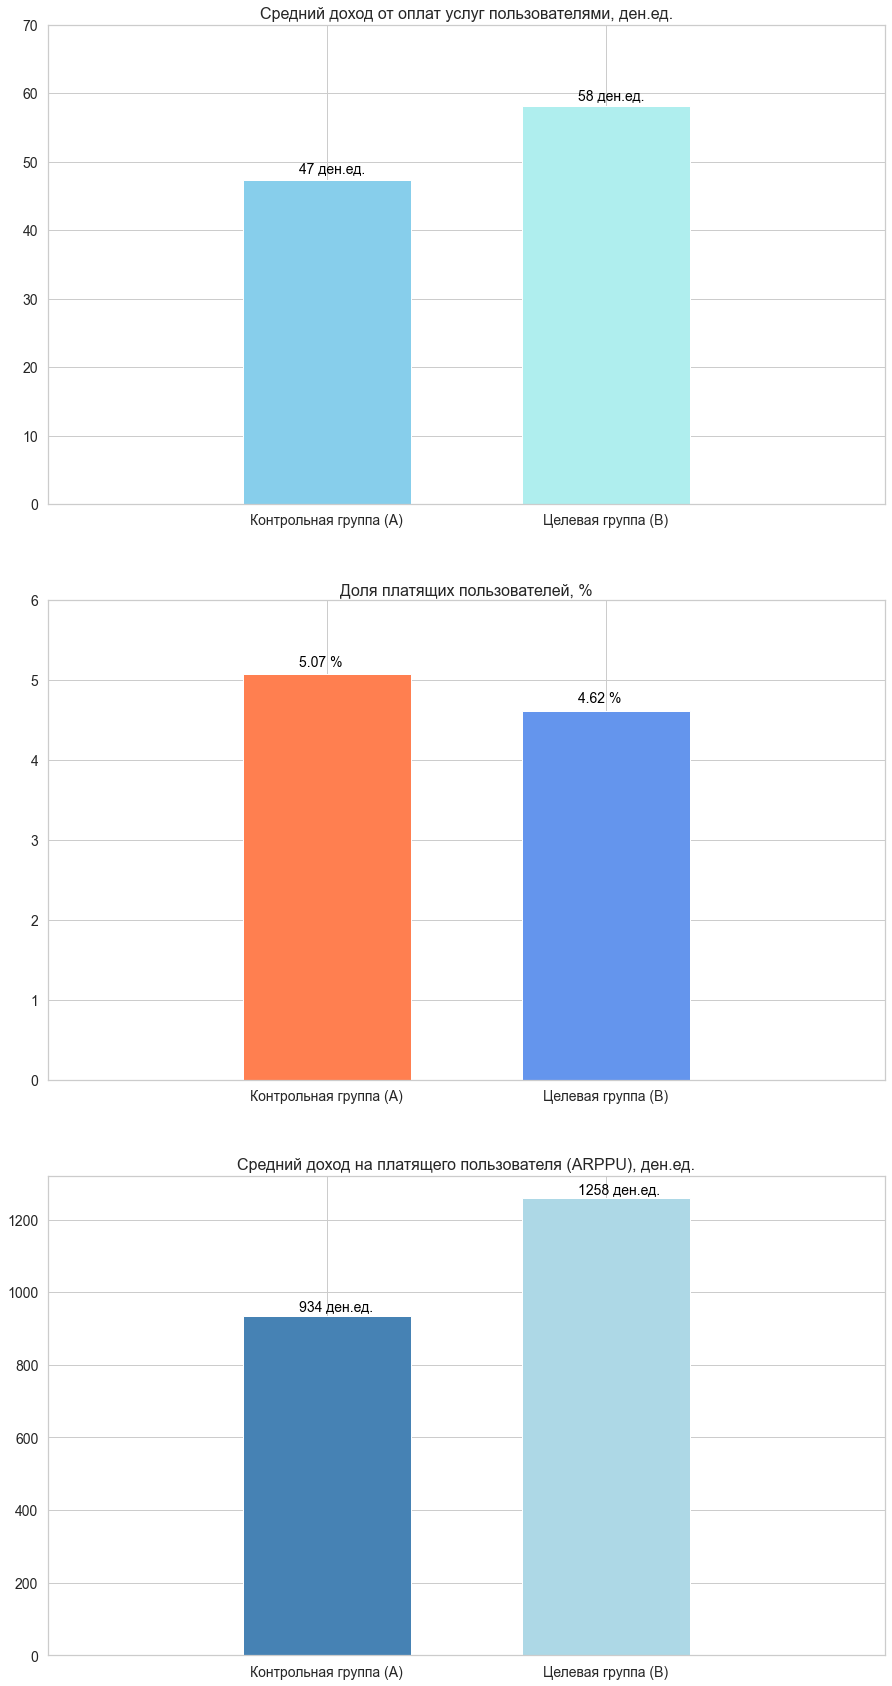

In [52]:
def plot_graphs():
    sns.set_palette('Dark2_r')
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(3, figsize=[15, 30])
    ax[0].set_title('Средний доход от оплат услуг пользователями, ден.ед.', size=16)
    ax[1].set_title('Доля платящих пользователей, %', size=16)
    ax[2].set_title('Средний доход на платящего пользователя (ARPPU), ден.ед.', size=16)
    ax[0].bar([1, 2], [update_metrics(df)[0][0], update_metrics(df)[0][1]], width=0.6,
              tick_label=['Контрольная группа (А)', 'Целевая группа (B)'], align='center',
              color=['skyblue', 'paleturquoise'])
    ax[1].bar([1, 2], [update_metrics(df)[0][2], update_metrics(df)[0][3]], width=0.6,
              tick_label=['Контрольная группа (А)', 'Целевая группа (B)'], align='center',
              color=['coral', 'cornflowerblue'])
    ax[2].bar([1, 2], [update_metrics(df)[0][4], update_metrics(df)[0][5]], width=0.6,
              tick_label=['Контрольная группа (А)', 'Целевая группа (B)'], align='center',
              color=['steelblue', 'lightblue'])
    style = dict(size=14, color='black')
    ax[0].text(0.9, update_metrics(df)[0][0] + 1, str(int(round(update_metrics(df)[0][0], 0))) + ' ден.ед.', **style)
    ax[0].text(1.9, update_metrics(df)[0][1] + 1, str(int(round(update_metrics(df)[0][1], 0))) + ' ден.ед.', **style)
    ax[1].text(0.9, update_metrics(df)[0][2] + 0.1, str(round(update_metrics(df)[0][2], 2)) + ' %', **style)
    ax[1].text(1.9, update_metrics(df)[0][3] + 0.1, str(round(update_metrics(df)[0][3], 2)) + ' %', **style)
    ax[2].text(0.9, update_metrics(df)[0][4] + 15, str(int(round(update_metrics(df)[0][4], 0))) + ' ден.ед.', **style)
    ax[2].text(1.9, update_metrics(df)[0][5] + 15, str(int(round(update_metrics(df)[0][5], 0))) + ' ден.ед.', **style)
    ax[0].set_xlim(0, 3)
    ax[0].set_ylim(0, 70)
    ax[1].set_xlim(0, 3)
    ax[1].set_ylim(0, 6)
    ax[2].set_xlim(0, 3)
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[2].tick_params(axis='both', which='major', labelsize=14)


plot_graphs()